<a href="https://colab.research.google.com/github/rakezhjab/Advanced-machine-learning-assessment/blob/main/Site_spec_weed_mgmt_(InceptionV3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing the libraries**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 34.5 MB/s 


In [3]:
pip install keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
pip install imgaug

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.image as img
import numpy as np
import os
import pandas as pd
import seaborn as sns
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.applications import vgg16
from tensorflow.keras.applications import inception_v3
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from mpl_toolkits.axes_grid1 import ImageGrid
from sklearn.metrics import accuracy_score, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import imgaug as ia
import imgaug.augmenters as iaa
from keras.utils import layer_utils
from tensorflow.keras.utils import to_categorical
from statistics import mean
import math
import cv2
from tensorflow import keras
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

**Resizing the image and Loading the dataset**

In [8]:
# re-size all the images
IMAGE_SIZE = [224, 224]
#loading the data
train_dir = r"/content/drive/MyDrive/data_task1/train"
test_dir = r"/content/drive/MyDrive/data_task1/test"
val_dir = r"/content/drive/MyDrive/data_task1/val"

**Visualisation of dataset**

In [9]:
datasets = [r"/content/drive/MyDrive/data_task1/train"]

Classes = ["blackgrass","charlock","cleavers","fat hen","maize","wheat"]

n_classes = len(Classes)

Classes

['blackgrass', 'charlock', 'cleavers', 'fat hen', 'maize', 'wheat']

**Augmentation process**

In [10]:
def augmentation_classes(Classes,train_dir):
    size_dict={}
    for i,classes in enumerate(Classes):
         size_dict[Classes[i]]=len(os.listdir(os.path.join(train_dir, classes)))
    print('Sample sizes of different classes are\n\n',size_dict)
    values_list=list(size_dict.values())
    ideal_samples=math.ceil(mean(values_list)*1.1)
    required_aug=[]
    for i,j in enumerate(size_dict):
        if size_dict[j]<ideal_samples:
            required_aug.append(j)
    print('\n\nMinority classes requiring augmentations are\n',required_aug)
    return required_aug,ideal_samples,size_dict

In [11]:
def image_augmentation(raw_images):
    
    
    seq=iaa.Sequential([iaa.Fliplr(0.5),
                        iaa.Flipud(0.3),
                        iaa.LinearContrast((0.75, 1.5)),
                        iaa.Crop(percent=(0, 0.2)),
                        iaa.Affine(rotate=(-45, 45)),
                        iaa.GaussianBlur(sigma=(0.0, 3.0))
                        ])
    image_aug=seq(images=raw_images)
    return image_aug

In [12]:
def preprocessing(img_path):
    image = cv2.resize(cv2.imread(img_path), (224,224), interpolation = cv2.INTER_NEAREST)
    return image

In [13]:
def get_training_data( model):
        
    if model == "resnet50":
        datagen = ImageDataGenerator(preprocessing_function = resnet50.preprocess_input, validation_split=0.15)
    elif model == "inceptionV3":
        datagen = ImageDataGenerator(preprocessing_function = inception_v3.preprocess_input, validation_split=0.15)
    elif model == 'vgg16':
        datagen = ImageDataGenerator(preprocessing_function = vgg16.preprocess_input, validation_split=0.15)

    train_data_den = datagen.flow_from_directory(
            directory= os.path.join(save_dir),
            class_mode = "categorical",
            batch_size=32,
            shuffle=True,
            subset='training'
        )
        
    val_data_gen = datagen.flow_from_directory(
            directory= os.path.join(save_dir),
            class_mode = 'categorical',
            batch_size=32,
            shuffle=False,
            subset='validation'
        )

    return train_data_den, val_data_gen

In [14]:
def augment_and_store_data(Classes,train_dir,save_dir,required_aug,ideal_samples,size_dict):
    for i,sample_class in enumerate(Classes):
        try:
            os.mkdir(os.path.join(save_dir,sample_class))
        except FileExistsError:
            pass
        img_list=[]
        for img_loc in os.listdir(os.path.join(train_dir,sample_class)):
            image = preprocessing(os.path.join(train_dir, sample_class, img_loc))
            img_list.append(image)
        if sample_class in required_aug:
            aug_img= image_augmentation(img_list)
            req_img=random.sample(aug_img,(ideal_samples-size_dict[sample_class]))
            img_list.extend(req_img)
        for image_number, image in enumerate(img_list):
            cv2.imwrite(os.path.join(save_dir, sample_class, "{}.png".format(image_number + 1)), image)

In [15]:
def model_prep(model_arch,monitor,lr_patience,early_stop_patience,min_lr):
    checkpoint = ModelCheckpoint(filepath=os.path.join(r'/content/drive/MyDrive/task1 file',model_arch,'.h5'), monitor='val_acc', mode='max', save_best_only=True)
    #reduce_lr = ReduceLROnPlateau(monitor=monitor, factor=0.2, patience=1, min_lr=min_lr)
    early_stop = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=12, verbose=1, mode='min', restore_best_weights=True)
    #CSVLogger logs epoch, acc, loss, val_acc, val_loss
    log_csv = CSVLogger('my_logs.csv', separator=',', append=False)
    callback=[checkpoint,early_stop, log_csv]
    train_gen, val_gen = get_training_data(model = model_arch)
    
    return callback,train_gen,val_gen

**Before Augmentation**

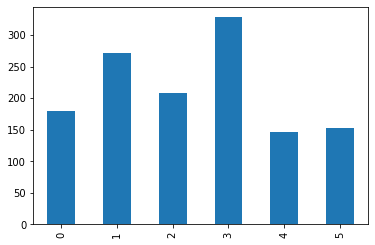

In [16]:
a={}
for i,classes in enumerate(Classes):
     a[i]=len(os.listdir(os.path.join(train_dir, classes)))
a=pd.DataFrame(a.items(),columns=['index','no.of samples'],index=a.keys())
a['no.of samples'].plot(kind='bar')
sample_size=a['no.of samples']

**Finding the classes needing for the augmentation**

In [17]:
required_aug,ideal_samples,size_dict = augmentation_classes(Classes,train_dir)

Sample sizes of different classes are

 {'blackgrass': 180, 'charlock': 272, 'cleavers': 208, 'fat hen': 328, 'maize': 146, 'wheat': 153}


Minority classes requiring augmentations are
 ['blackgrass', 'cleavers', 'maize', 'wheat']


**Augmenting and storing data**

In [19]:
save_dir = r"/content/drive/MyDrive/task1 file"

In [20]:
augment_and_store_data(Classes,train_dir,save_dir,required_aug,ideal_samples,size_dict)

**After augmentation**

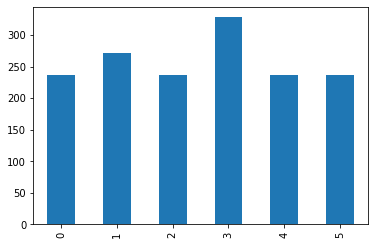

In [21]:
c={}
for i,classes in enumerate(Classes):
     c[i]=len(os.listdir(os.path.join(save_dir, classes)))
c=pd.DataFrame(c.items(),columns=['index','no.of samples'],index=c.keys())
c['no.of samples'].plot(kind='bar')
sample_size=a['no.of samples']

**Model Training**

In [22]:
from tensorflow.keras.callbacks import CSVLogger

In [23]:
callback,train_gen,val_gen=model_prep('inceptionV3','val_loss',2,5,0.000001)

Found 1315 images belonging to 6 classes.
Found 229 images belonging to 6 classes.


In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns

from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [25]:
# useful for getting number of classes
folders = glob(r"/content/drive/MyDrive/data_task1/train/*")

In [47]:

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Dropout
from tensorflow.keras.models import Model

inception_model = InceptionV3(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
x = inception_model.output
x = Flatten()(x)
#x = Dense(128,activation = "relu")(x)
#x = Dropout(0.5)(x)
pred = Dense(6,activation = "softmax")(x)
model = Model(inputs = inception_model.input,outputs = pred)

for layers in inception_model.layers:
    layers.trainable = False

model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [48]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_752 (Conv2D)            (None, 111, 111, 32  864         ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_753 (Batch  (None, 111, 111, 32  96         ['conv2d_752[0][0]']             
 Normalization)                 )                                                           

In [49]:
history = model.fit_generator(
  train_gen,
  validation_data=val_gen,
  epochs=50,
  steps_per_epoch=len(train_gen),
  validation_steps=len(val_gen),
callbacks= callback)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


42/42 [==============================] - ETA: 0s - loss: 1.7002 - accuracy: 0.3354

42/42 [==============================] - 15s 242ms/step - loss: 1.7002 - accuracy: 0.3354 - val_loss: 1.6234 - val_accuracy: 0.3231
Epoch 2/50
42/42 [==============================] - ETA: 0s - loss: 1.4744 - accuracy: 0.4403

42/42 [==============================] - 7s 176ms/step - loss: 1.4744 - accuracy: 0.4403 - val_loss: 1.4723 - val_accuracy: 0.3930
Epoch 3/50
42/42 [==============================] - ETA: 0s - loss: 1.3210 - accuracy: 0.5278

42/42 [==============================] - 7s 177ms/step - loss: 1.3210 - accuracy: 0.5278 - val_loss: 1.3523 - val_accuracy: 0.4760
Epoch 4/50
42/42 [==============================] - ETA: 0s - loss: 1.2048 - accuracy: 0.5962

42/42 [==============================] - 7s 176ms/step - loss: 1.2048 - accuracy: 0.5962 - val_loss: 1.2540 - val_accuracy: 0.5328
Epoch 5/50
42/42 [==============================] - ETA: 0s - loss: 1.1060 - accuracy: 0.6312

42/42 [==============================] - 7s 177ms/step - loss: 1.1060 - accuracy: 0.6312 - val_loss: 1.1720 - val_accuracy: 0.5808
Epoch 6/50
42/42 [==============================] - ETA: 0s - loss: 1.0246 - accuracy: 0.6783

42/42 [==============================] - 7s 179ms/step - loss: 1.0246 - accuracy: 0.6783 - val_loss: 1.0998 - val_accuracy: 0.6114
Epoch 7/50
42/42 [==============================] - ETA: 0s - loss: 0.9623 - accuracy: 0.7004

42/42 [==============================] - 7s 174ms/step - loss: 0.9623 - accuracy: 0.7004 - val_loss: 1.0450 - val_accuracy: 0.6288
Epoch 8/50
42/42 [==============================] - ETA: 0s - loss: 0.9032 - accuracy: 0.7300

42/42 [==============================] - 7s 175ms/step - loss: 0.9032 - accuracy: 0.7300 - val_loss: 1.0034 - val_accuracy: 0.6419
Epoch 9/50
42/42 [==============================] - ETA: 0s - loss: 0.8490 - accuracy: 0.7536

42/42 [==============================] - 7s 175ms/step - loss: 0.8490 - accuracy: 0.7536 - val_loss: 0.9608 - val_accuracy: 0.6594
Epoch 10/50
42/42 [==============================] - ETA: 0s - loss: 0.8046 - accuracy: 0.7665

42/42 [==============================] - 7s 176ms/step - loss: 0.8046 - accuracy: 0.7665 - val_loss: 0.9186 - val_accuracy: 0.7205
Epoch 11/50
42/42 [==============================] - ETA: 0s - loss: 0.7646 - accuracy: 0.7871

42/42 [==============================] - 7s 177ms/step - loss: 0.7646 - accuracy: 0.7871 - val_loss: 0.8872 - val_accuracy: 0.7162
Epoch 12/50
42/42 [==============================] - ETA: 0s - loss: 0.7315 - accuracy: 0.7985

42/42 [==============================] - 7s 175ms/step - loss: 0.7315 - accuracy: 0.7985 - val_loss: 0.8676 - val_accuracy: 0.7118
Epoch 13/50
42/42 [==============================] - ETA: 0s - loss: 0.6959 - accuracy: 0.8129

42/42 [==============================] - 7s 174ms/step - loss: 0.6959 - accuracy: 0.8129 - val_loss: 0.8325 - val_accuracy: 0.7336
Epoch 14/50
42/42 [==============================] - ETA: 0s - loss: 0.6702 - accuracy: 0.8190

42/42 [==============================] - 8s 190ms/step - loss: 0.6702 - accuracy: 0.8190 - val_loss: 0.8074 - val_accuracy: 0.7336
Epoch 15/50
42/42 [==============================] - ETA: 0s - loss: 0.6427 - accuracy: 0.8357

42/42 [==============================] - 7s 175ms/step - loss: 0.6427 - accuracy: 0.8357 - val_loss: 0.7871 - val_accuracy: 0.7424
Epoch 16/50
42/42 [==============================] - ETA: 0s - loss: 0.6196 - accuracy: 0.8312

42/42 [==============================] - 7s 175ms/step - loss: 0.6196 - accuracy: 0.8312 - val_loss: 0.7693 - val_accuracy: 0.7380
Epoch 17/50
42/42 [==============================] - ETA: 0s - loss: 0.5972 - accuracy: 0.8487

42/42 [==============================] - 7s 176ms/step - loss: 0.5972 - accuracy: 0.8487 - val_loss: 0.7450 - val_accuracy: 0.7467
Epoch 18/50
41/42 [============================>.] - ETA: 0s - loss: 0.5758 - accuracy: 0.8575

42/42 [==============================] - 8s 196ms/step - loss: 0.5756 - accuracy: 0.8578 - val_loss: 0.7277 - val_accuracy: 0.7511
Epoch 19/50
42/42 [==============================] - ETA: 0s - loss: 0.5608 - accuracy: 0.8563

42/42 [==============================] - 8s 178ms/step - loss: 0.5608 - accuracy: 0.8563 - val_loss: 0.7049 - val_accuracy: 0.7817
Epoch 20/50
42/42 [==============================] - ETA: 0s - loss: 0.5397 - accuracy: 0.8669

42/42 [==============================] - 7s 176ms/step - loss: 0.5397 - accuracy: 0.8669 - val_loss: 0.6994 - val_accuracy: 0.7467
Epoch 21/50
42/42 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.8730

42/42 [==============================] - 7s 176ms/step - loss: 0.5228 - accuracy: 0.8730 - val_loss: 0.6780 - val_accuracy: 0.7729
Epoch 22/50
41/42 [============================>.] - ETA: 0s - loss: 0.5079 - accuracy: 0.8796

42/42 [==============================] - 7s 175ms/step - loss: 0.5078 - accuracy: 0.8798 - val_loss: 0.6631 - val_accuracy: 0.7642
Epoch 23/50
42/42 [==============================] - ETA: 0s - loss: 0.4950 - accuracy: 0.8814

42/42 [==============================] - 7s 175ms/step - loss: 0.4950 - accuracy: 0.8814 - val_loss: 0.6572 - val_accuracy: 0.7642
Epoch 24/50
42/42 [==============================] - ETA: 0s - loss: 0.4804 - accuracy: 0.8882

42/42 [==============================] - 7s 176ms/step - loss: 0.4804 - accuracy: 0.8882 - val_loss: 0.6432 - val_accuracy: 0.7555
Epoch 25/50
42/42 [==============================] - ETA: 0s - loss: 0.4671 - accuracy: 0.8928

42/42 [==============================] - 7s 174ms/step - loss: 0.4671 - accuracy: 0.8928 - val_loss: 0.6335 - val_accuracy: 0.7729
Epoch 26/50
42/42 [==============================] - ETA: 0s - loss: 0.4610 - accuracy: 0.8928

42/42 [==============================] - 7s 177ms/step - loss: 0.4610 - accuracy: 0.8928 - val_loss: 0.6240 - val_accuracy: 0.7555
Epoch 27/50
42/42 [==============================] - ETA: 0s - loss: 0.4453 - accuracy: 0.8981

42/42 [==============================] - 7s 176ms/step - loss: 0.4453 - accuracy: 0.8981 - val_loss: 0.6113 - val_accuracy: 0.7642
Epoch 28/50
42/42 [==============================] - ETA: 0s - loss: 0.4335 - accuracy: 0.8951

42/42 [==============================] - 7s 175ms/step - loss: 0.4335 - accuracy: 0.8951 - val_loss: 0.6039 - val_accuracy: 0.7598
Epoch 29/50
42/42 [==============================] - ETA: 0s - loss: 0.4246 - accuracy: 0.9034

42/42 [==============================] - 7s 175ms/step - loss: 0.4246 - accuracy: 0.9034 - val_loss: 0.5835 - val_accuracy: 0.7904
Epoch 30/50
42/42 [==============================] - ETA: 0s - loss: 0.4137 - accuracy: 0.9057

42/42 [==============================] - 7s 172ms/step - loss: 0.4137 - accuracy: 0.9057 - val_loss: 0.5840 - val_accuracy: 0.7773
Epoch 31/50
42/42 [==============================] - ETA: 0s - loss: 0.4032 - accuracy: 0.9080

42/42 [==============================] - 7s 175ms/step - loss: 0.4032 - accuracy: 0.9080 - val_loss: 0.5754 - val_accuracy: 0.7729
Epoch 32/50
42/42 [==============================] - ETA: 0s - loss: 0.3950 - accuracy: 0.9095

42/42 [==============================] - 7s 176ms/step - loss: 0.3950 - accuracy: 0.9095 - val_loss: 0.5718 - val_accuracy: 0.7860
Epoch 33/50
42/42 [==============================] - ETA: 0s - loss: 0.3885 - accuracy: 0.9156

42/42 [==============================] - 7s 174ms/step - loss: 0.3885 - accuracy: 0.9156 - val_loss: 0.5578 - val_accuracy: 0.7860
Epoch 34/50
42/42 [==============================] - ETA: 0s - loss: 0.3789 - accuracy: 0.9156

42/42 [==============================] - 7s 176ms/step - loss: 0.3789 - accuracy: 0.9156 - val_loss: 0.5512 - val_accuracy: 0.7817
Epoch 35/50
42/42 [==============================] - ETA: 0s - loss: 0.3705 - accuracy: 0.9202

42/42 [==============================] - 7s 170ms/step - loss: 0.3705 - accuracy: 0.9202 - val_loss: 0.5520 - val_accuracy: 0.7729
Epoch 36/50
42/42 [==============================] - ETA: 0s - loss: 0.3654 - accuracy: 0.9148

42/42 [==============================] - 7s 175ms/step - loss: 0.3654 - accuracy: 0.9148 - val_loss: 0.5410 - val_accuracy: 0.7729
Epoch 37/50
42/42 [==============================] - ETA: 0s - loss: 0.3563 - accuracy: 0.9179

42/42 [==============================] - 8s 178ms/step - loss: 0.3563 - accuracy: 0.9179 - val_loss: 0.5341 - val_accuracy: 0.7729
Epoch 38/50
42/42 [==============================] - ETA: 0s - loss: 0.3490 - accuracy: 0.9240

42/42 [==============================] - 7s 177ms/step - loss: 0.3490 - accuracy: 0.9240 - val_loss: 0.5276 - val_accuracy: 0.8035
Epoch 39/50
42/42 [==============================] - ETA: 0s - loss: 0.3429 - accuracy: 0.9240

42/42 [==============================] - 7s 174ms/step - loss: 0.3429 - accuracy: 0.9240 - val_loss: 0.5182 - val_accuracy: 0.7991
Epoch 40/50
42/42 [==============================] - ETA: 0s - loss: 0.3371 - accuracy: 0.9255

42/42 [==============================] - 7s 170ms/step - loss: 0.3371 - accuracy: 0.9255 - val_loss: 0.5185 - val_accuracy: 0.7904
Epoch 41/50
42/42 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.9278

42/42 [==============================] - 7s 176ms/step - loss: 0.3299 - accuracy: 0.9278 - val_loss: 0.5121 - val_accuracy: 0.7817
Epoch 42/50
42/42 [==============================] - ETA: 0s - loss: 0.3236 - accuracy: 0.9270

42/42 [==============================] - 7s 176ms/step - loss: 0.3236 - accuracy: 0.9270 - val_loss: 0.5071 - val_accuracy: 0.7991
Epoch 43/50
42/42 [==============================] - ETA: 0s - loss: 0.3176 - accuracy: 0.9308

42/42 [==============================] - 7s 176ms/step - loss: 0.3176 - accuracy: 0.9308 - val_loss: 0.4995 - val_accuracy: 0.7948
Epoch 44/50
42/42 [==============================] - ETA: 0s - loss: 0.3123 - accuracy: 0.9346

42/42 [==============================] - 7s 175ms/step - loss: 0.3123 - accuracy: 0.9346 - val_loss: 0.4955 - val_accuracy: 0.7948
Epoch 45/50
42/42 [==============================] - ETA: 0s - loss: 0.3087 - accuracy: 0.9354

42/42 [==============================] - 7s 174ms/step - loss: 0.3087 - accuracy: 0.9354 - val_loss: 0.4895 - val_accuracy: 0.8079
Epoch 46/50
42/42 [==============================] - ETA: 0s - loss: 0.3028 - accuracy: 0.9392

42/42 [==============================] - 7s 173ms/step - loss: 0.3028 - accuracy: 0.9392 - val_loss: 0.4807 - val_accuracy: 0.8210
Epoch 47/50
42/42 [==============================] - ETA: 0s - loss: 0.2968 - accuracy: 0.9392

42/42 [==============================] - 7s 170ms/step - loss: 0.2968 - accuracy: 0.9392 - val_loss: 0.4836 - val_accuracy: 0.8079
Epoch 48/50
42/42 [==============================] - ETA: 0s - loss: 0.2905 - accuracy: 0.9445

42/42 [==============================] - 7s 171ms/step - loss: 0.2905 - accuracy: 0.9445 - val_loss: 0.4826 - val_accuracy: 0.7991
Epoch 49/50
42/42 [==============================] - ETA: 0s - loss: 0.2875 - accuracy: 0.9407

42/42 [==============================] - 7s 175ms/step - loss: 0.2875 - accuracy: 0.9407 - val_loss: 0.4733 - val_accuracy: 0.8166
Epoch 50/50
42/42 [==============================] - ETA: 0s - loss: 0.2821 - accuracy: 0.9452

42/42 [==============================] - 7s 175ms/step - loss: 0.2821 - accuracy: 0.9452 - val_loss: 0.4691 - val_accuracy: 0.7991


In [51]:
model.save('/content/drive/MyDrive/save file task 1/InceptionV3_models.hdf5')

Values stored in history are ... 
 {'loss': [1.7002432346343994, 1.4744279384613037, 1.3209630250930786, 1.2047637701034546, 1.1059744358062744, 1.024600863456726, 0.962278425693512, 0.9031794667243958, 0.8489938378334045, 0.8045562505722046, 0.7646101117134094, 0.7315166592597961, 0.695885419845581, 0.6701862812042236, 0.6426981091499329, 0.6196117401123047, 0.5972018241882324, 0.5755597352981567, 0.5607506632804871, 0.5396814346313477, 0.5228050351142883, 0.5078247785568237, 0.4950231909751892, 0.4803822934627533, 0.46714359521865845, 0.46101391315460205, 0.4452996850013733, 0.43349701166152954, 0.42458420991897583, 0.41368263959884644, 0.4031522572040558, 0.3950048089027405, 0.3884710669517517, 0.37892115116119385, 0.3705168664455414, 0.3654070198535919, 0.35628411173820496, 0.34904584288597107, 0.3429325819015503, 0.3370634615421295, 0.32991650700569153, 0.3236106038093567, 0.3176494836807251, 0.3123452067375183, 0.3087312579154968, 0.3027826249599457, 0.2967601716518402, 0.2905316

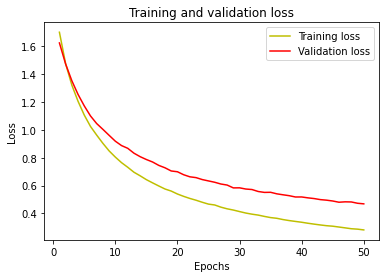

In [52]:
#plot the training and validation accuracy and loss at each epoch
print("Values stored in history are ... \n", history.history)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Values stored in history are ... 
 {'loss': [1.7002432346343994, 1.4744279384613037, 1.3209630250930786, 1.2047637701034546, 1.1059744358062744, 1.024600863456726, 0.962278425693512, 0.9031794667243958, 0.8489938378334045, 0.8045562505722046, 0.7646101117134094, 0.7315166592597961, 0.695885419845581, 0.6701862812042236, 0.6426981091499329, 0.6196117401123047, 0.5972018241882324, 0.5755597352981567, 0.5607506632804871, 0.5396814346313477, 0.5228050351142883, 0.5078247785568237, 0.4950231909751892, 0.4803822934627533, 0.46714359521865845, 0.46101391315460205, 0.4452996850013733, 0.43349701166152954, 0.42458420991897583, 0.41368263959884644, 0.4031522572040558, 0.3950048089027405, 0.3884710669517517, 0.37892115116119385, 0.3705168664455414, 0.3654070198535919, 0.35628411173820496, 0.34904584288597107, 0.3429325819015503, 0.3370634615421295, 0.32991650700569153, 0.3236106038093567, 0.3176494836807251, 0.3123452067375183, 0.3087312579154968, 0.3027826249599457, 0.2967601716518402, 0.2905316

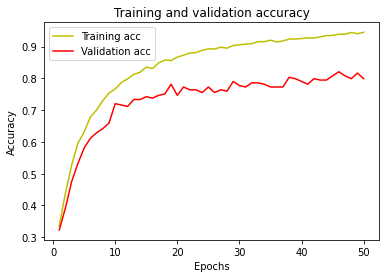

In [53]:
#plot the training and validation accuracy and loss at each epoch
print("Values stored in history are ... \n", history.history)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Confusion matrix and prediction**

In [ ]:
incep_model = keras.models.load_model('/content/drive/MyDrive/InceptionV3_models.hdf5')

In [55]:
callback,train_gen,val_gen=model_prep('inceptionV3','val_loss',2,5,0.000001)
model.evaluate_generator(generator=val_gen)

Found 1315 images belonging to 6 classes.
Found 229 images belonging to 6 classes.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


[0.46907782554626465, 0.7991266250610352]

In [56]:
predictions = model.predict_generator(val_gen,28)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


Classification Report
              precision    recall  f1-score   support

  blackgrass       0.71      0.71      0.71        35
    charlock       0.80      0.90      0.85        40
    cleavers       0.83      0.86      0.85        35
     fat hen       0.76      0.78      0.77        49
       maize       0.97      0.86      0.91        35
       wheat       0.75      0.69      0.72        35

    accuracy                           0.80       229
   macro avg       0.80      0.80      0.80       229
weighted avg       0.80      0.80      0.80       229



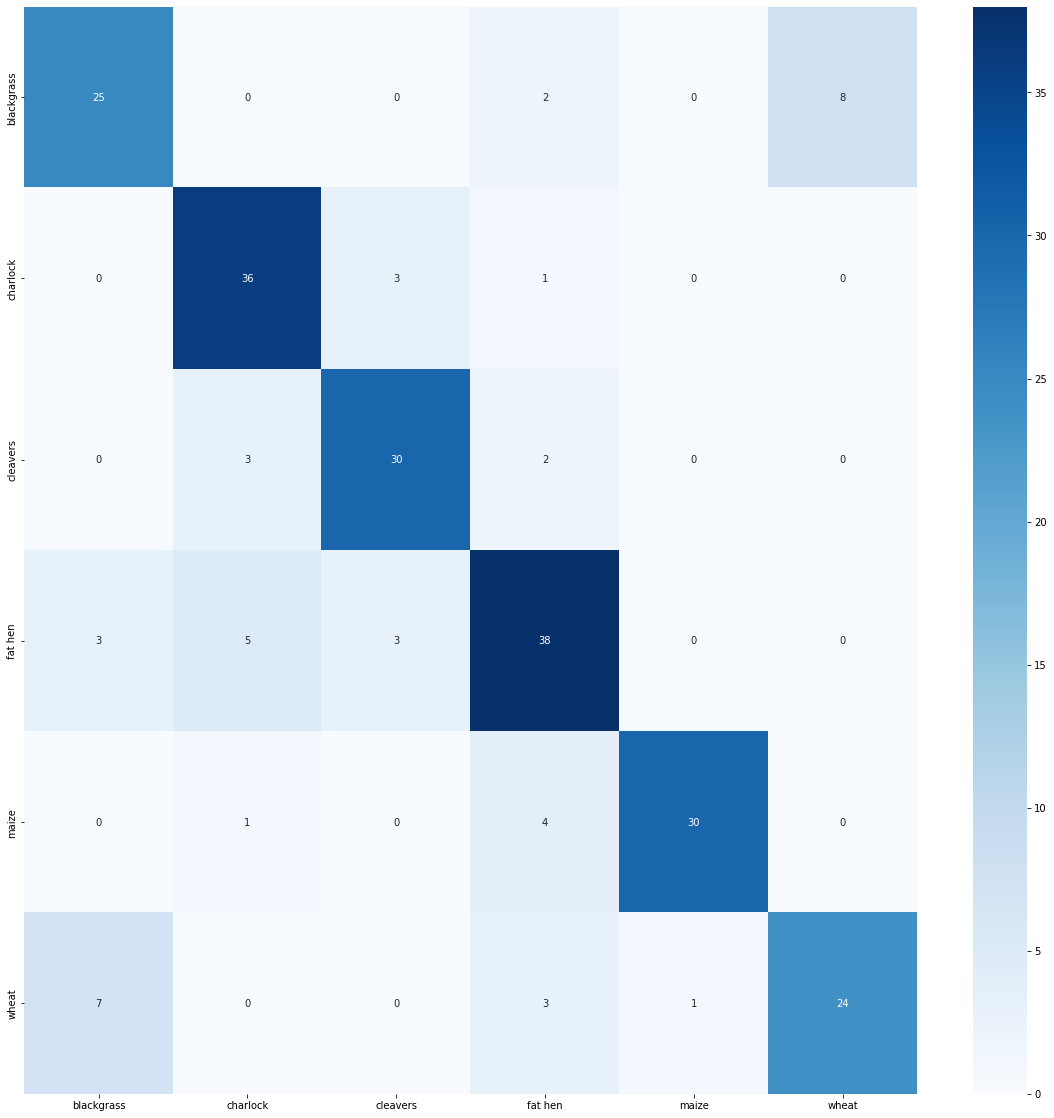

In [57]:
y_pred = np.argmax(predictions, axis=1)
cf_matrix = confusion_matrix(val_gen.classes, y_pred)
print('Classification Report')
print(classification_report(val_gen.classes, y_pred, target_names=Classes))
plt.figure(figsize=(20,20))
sns.heatmap(cf_matrix, annot=True, xticklabels=Classes, yticklabels=Classes, cmap='Blues')